Title: Connected Component Labeling
Author: Thomas Breuel
Institution: UniKL

In [1]:

from scipy.ndimage import filters
def ims(image,**kw):
    size = kw.get("s",8)
    if "s" in kw: del kw["s"]
    subplots(1,1,figsize=(size,size))
    gray(); imshow(image,**kw)
def imp(image,**kw):
    subplots(1,1,figsize=(6,6))
    gray(); imshow(image,interpolation='nearest',**kw)
def imrow(*args,**kw):
    size = kw.get("s",8)
    if "s" in kw: del kw["s"]
    n = len(args)
    gray()
    subplots(1,n,figsize=(n*size,size))
    for i,im in enumerate(args):
        subplot(1,n,i+1); imshow(im,**kw)
def rescale(image):
    return (image-amin(image))/max(1e-4,amax(image)-amin(image))

Connected Component Labeling
============================

We have been using binary images and morphology.

At some point, it becomes important to turn the parts
of binary images into "objects".

This is a common operation in artificial intelligence:

- start with an analog signal
- turn it into a binary signal somehow
- divide the binary signal into objects
- represent each object as a _symbol_
- continue with _symbolic processing_

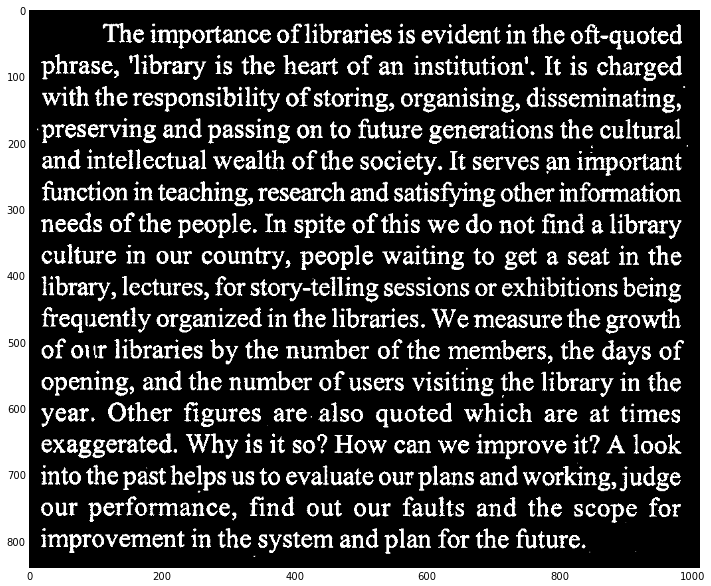

In [2]:
image = mean(imread("testpar.png"),axis=2)
image /= amax(image)
image = 1-image
imrow(image,s=12)

In [3]:
from scipy.ndimage import measurements,morphology

Labeling is carried out with the `label` function.

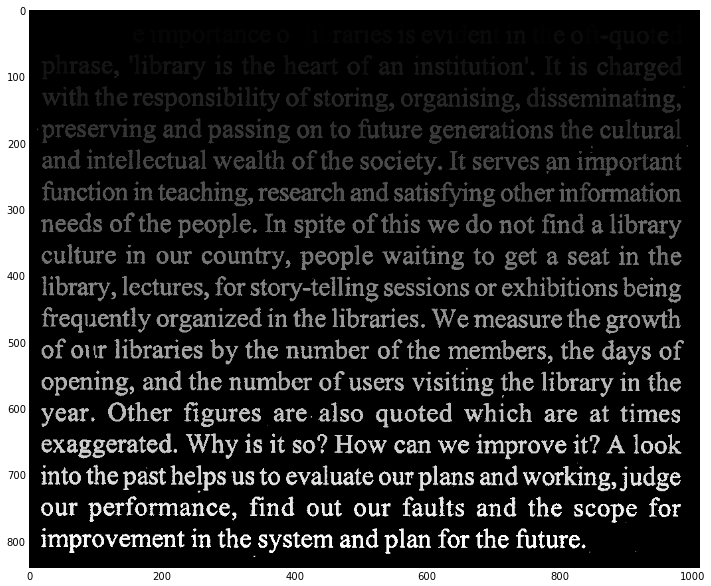

In [4]:
labels,n = measurements.label(image>0.5)
imrow(labels,s=12)

That's not very illuminating.
Let's instead recolor the gray values pseudo-randomly.
The function `recolor` does this, keeping the value 0 as black.
We use the `spectral` color map, which gives us a wide range
of colors.

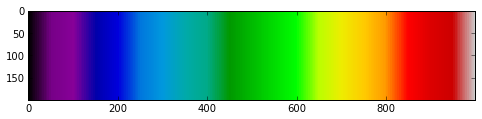

In [5]:
imrow(mgrid[:200,:1000][1]/1000.0,cmap=cm.spectral)

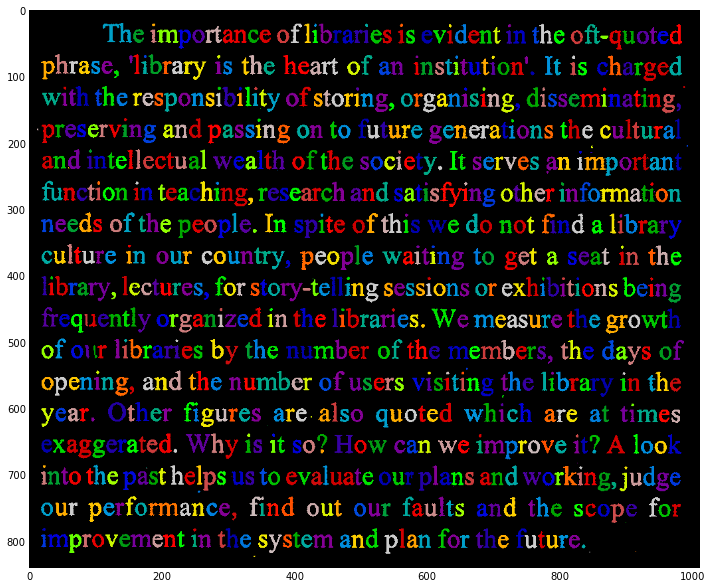

In [6]:
def recolor(labels): return where(labels>0,sin(100*labels)**2+0.1,0)
imrow(recolor(labels),cmap=cm.spectral,s=12)

So, the `label` function assigns a different color to each connected component.

A connected component is defined on the *pixel adjacency graph*.

We define two ON pixels as neighbors if they are next to each other horizontally or vertically.

**Definition:** Two pixels are in the same connected component if they are (immediate) neighbors 
or if the first pixel is in the same connected component as a neighbor of the second pixel.

This definition is consistent with the definition of the connected coponents of a graph.

There are various efficient algorithms for connected component labeling,
including parallel algorithms.
Asymptotically, these algorithms run in (nearly) linear time.

# Algorithms for Connected Component Labeling

Let's look at the connected component labeling algorithm.

We're going to present a serial algorithm (i.e., without Python array optimizations).

We keep track of the labels in a new array `a`.



In [7]:
a = -array(image,'i')

For implementing connected component labeling, we need a data structure that keeps track of of sets of pixels.

The operations are:

- make a new set and return an integer identifier
- find a canonical representative for a given set
- make a union of two sets

When we are all done, we can map each element of a set to a single representative.

In [8]:
class UnionFind:
    def __init__(self):
        self.parents = []
    def set(self):
        i = len(self.parents)
        self.parents.append(i)
        return i
    def find(self,i):
        if self.parents[i]==i: return i
        self.parents[i] = self.find(self.parents[i])
        return self.parents[i]
    def union(self,i,j):
        i = self.find(i)
        j = self.find(j)
        if rand()<0.5: self.parents[i] = j
        else: self.parents[j] = i

This is the meat of the algorithm. There are four cases:

- off pixels are just skipped
- if a pixel is on and the pixel to the left is on, it assumes the label of the pixel to the left
- if a pixel is on and the pixel above is on, it assumes the label of the pixel above
- if there is a conflict, we make a union of the two sets

In [9]:
table = UnionFind()

for i in range(1,a.shape[0]):
    for j in range(1,a.shape[1]):
        if a[i,j]==0: 
            pass
        elif a[i,j-1]>0: 
            # pixel to the left is on
            a[i,j] = a[i,j-1]
            # both left and above are on
            if a[i-1,j]>0: table.union(a[i-1,j],a[i,j])
        elif a[i-1,j]>0:
            # only pixel above is on
            a[i,j] = a[i-1,j]
        else:
            # ths pixel is on, but neither left or above are
            a[i,j] = table.set()
            

After labeling, we map each pixel to its canonical representative.



In [10]:
for i in range(1,a.shape[0]):
    for j in range(1,a.shape[1]):
        a[i,j] = table.find(a[i,j])

The canonical representatives chosen by `UnionFind` aren't contiguous, so we need to remap the labels. Note that this ends up remapping 0 to 0.


In [11]:
remap = {v:i for i,v in enumerate(unique(a))}
assert remap[0]==0

for i in range(1,a.shape[0]):
    for j in range(1,a.shape[1]):
        a[i,j] = remap[a[i,j]]

Let's look at the output.



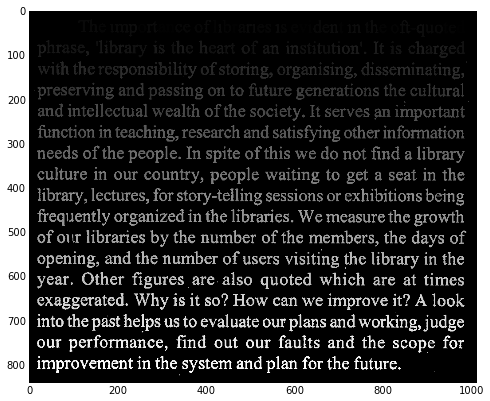

In [12]:
figsize(8,8)
imshow(a)

Or the output in color, as before.



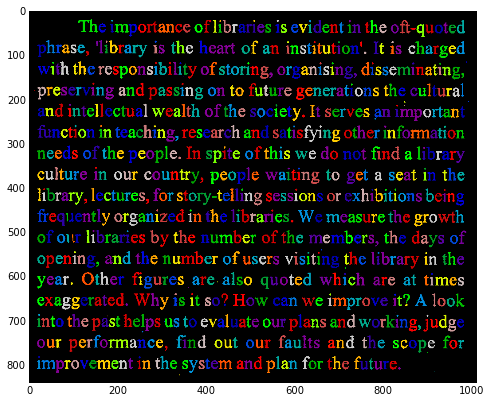

In [13]:
figsize(8,8)
imshow(recolor(a),cmap=cm.spectral)

Operations over Labeled Regions
===============================

There is a variety of image processing operations that can be carried out
over labeled regions.

For example, the `measurements.sum` function (not to be confused with the `pylab.sum`
function), sums all the values of the first arguments over each of the regions
defined by the labels of the second argument, for the labels listed in the third
argument.

Applied to the image above, this gives us the distibution of sizes of
each of the connected component (since the image has just values of 0 and 1).

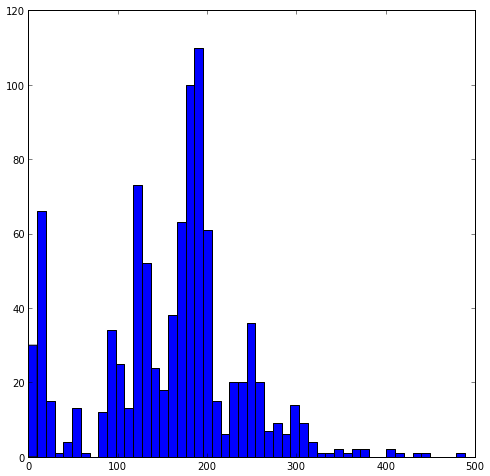

In [14]:
sizes = measurements.sum(image,labels,range(n+1))
_=hist(sizes,bins=50)

This combines in interesting ways with subscripting.

We have a 1D array of sizes and a 2D array of labels.
Subscripting with arrays returns, for each element of the subscript,
the value of the array being subscripted.

So, here is a simple way of removing small or large connected
components from an image.

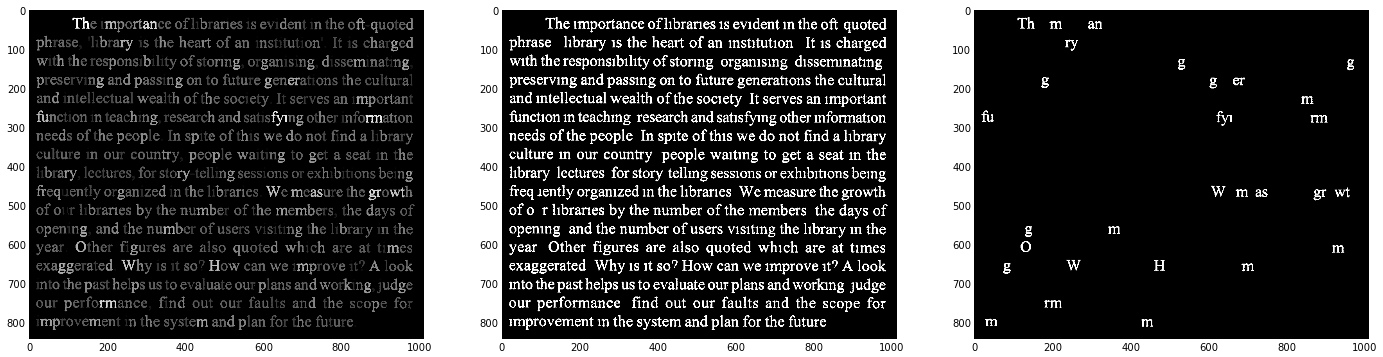

In [15]:
lsizes = sizes[labels]
imrow(lsizes,lsizes>80,lsizes>300)

Finding Objects
===============

Although labeling is useful by itself, often, we want to _extract_ images corresponding
to the labels.

For doing this, we use `measurements.find_objects`.
It returns a list of pairs of slices.
Each `slice(a,b,c)` is a data structure representing
array subscript notation like `a:b:c`.
So, the first element of the result represents the
subscript `[15:17,338:341]`, but without any array
to be subscripted.

These two slices together define the _bounding box_ of a connected component.

In [16]:
# find objects finds connected components
objects = measurements.find_objects(labels)
objects[:3]

[(slice(21L, 51L, None), slice(111L, 155L, None)),
 (slice(22L, 26L, None), slice(185L, 190L, None)),
 (slice(22L, 51L, None), slice(394L, 411L, None))]

(slice subscripting)

We can directly subscript with tuples of slices.

When we do this for the result of `find_objects`, we get pictures of all
the connected components.


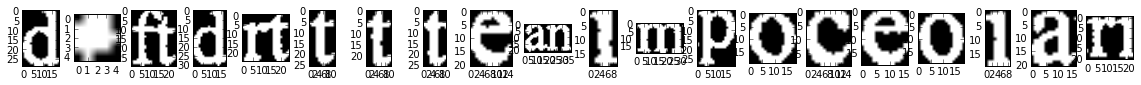

In [17]:
subimages = [image[s] for s in objects[10:30]]
imrow(*subimages,s=1)

(subscripting with label selection)

But the above is not quite right: if the bounding boxes of two connected components overlap,
we possibly get pixels from both connected components within each bounding box.
We actually need to _mask_ the image with a mask computed from the labels.



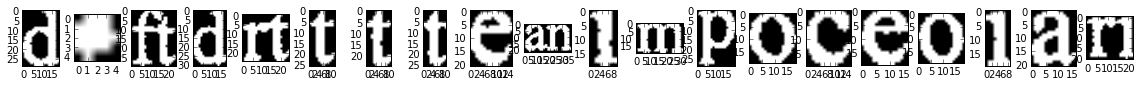

In [18]:
images = [image[s] * (labels[s]==i+1) for i,s in list(enumerate(objects))[10:30]]
imrow(*images,s=1)

(connected component measurements)

Now that we have the isolated images, we can compute properties of each object in isolation.

Common measurements on isolated objects are the _aspect ratio_ and the _bounding box area_.

As this example shows, these simple measurements already characterize objects quite well.

The example also shows that dividing an image into components by bounding boxes does not
always work, since the characters are not actually separated in the images of `wt`, `as`,
`rm`, and `er`.  

When we are interested in indivual characters, these images are _segmentation errors_.

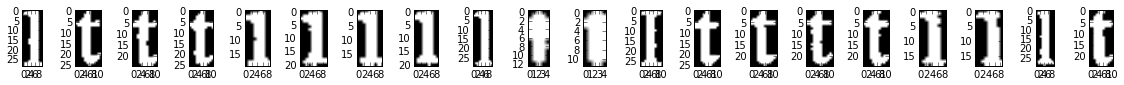

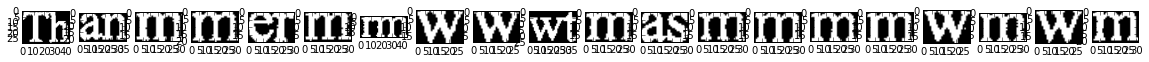

In [19]:
# shape descriptors
def aspect(s):
    return (s[0].stop-s[0].start)*1.0/(s[1].stop-s[1].start)
def bbarea(s):
    return (s[0].stop-s[0].start)*(s[1].stop-s[1].start)
tall = [image[s] for s in objects if aspect(s)>2.0]
imrow(*tall[:20],s=1)
wide = [image[s] for s in objects if aspect(s)<0.7 and bbarea(s)>100]
imrow(*wide[:20],s=1)

Of course, the next step after this kind of segmentation is to try to recognize
the characters.  We will be looking at techniques for doing this later in the course.